2025-07-28 12:01:26.083970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 12:01:26.168514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 12:01:26.179406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-28 12:01:27.693018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


--- Visualizing Model Architectures ---


2025-07-28 12:01:33.193044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: tesla
2025-07-28 12:01:33.193108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: tesla
2025-07-28 12:01:33.193408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-07-28 12:01:33.193494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 575.64.3


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Student model architecture plot saved.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Teacher model architecture plot saved.


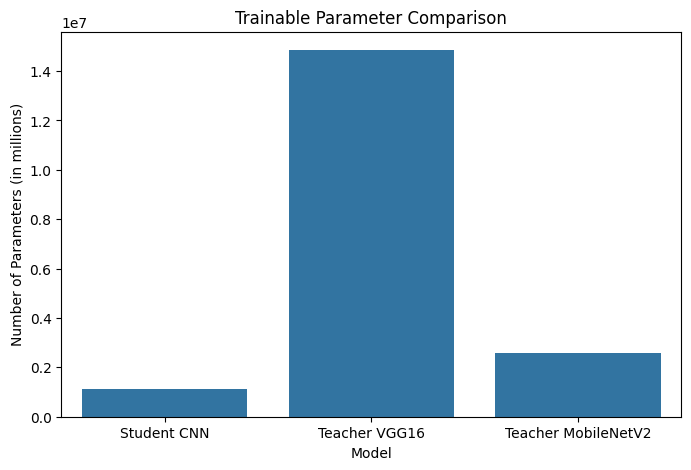


--- EXPERIMENT 1: TRAINING STUDENT (BASELINE) ---
Epoch 1/100


2025-07-28 12:01:39.474155: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


391/391 [==============================] - 194s 488ms/step - loss: 1.6884 - accuracy: 0.4142 - val_loss: 3.1901 - val_accuracy: 0.2157
Epoch 2/100
391/391 [==============================] - 206s 526ms/step - loss: 1.2521 - accuracy: 0.5510 - val_loss: 1.0852 - val_accuracy: 0.6163
Epoch 3/100
368/391 [===========================>..] - ETA: 10s - loss: 1.0846 - accuracy: 0.6191

KeyboardInterrupt: 

In [1]:
# -*- coding: utf-8 -*-
"""
Knowledge_Distillation_Enhanced_Visualization.py

This script demonstrates knowledge distillation with enhanced visualizations to provide a
comprehensive analysis of model performance.
"""

# STEP 1: ENHANCED SETUP AND HELPER FUNCTIONS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.losses import KLDivergence, CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Create a directory to save plots
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
y_train_cat, y_test_cat = to_categorical(y_train, 10), to_categorical(y_test, 10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# --- Helper Functions for Plotting ---

def plot_result(history, title):
    """Plots training history for a single model."""
    plt.figure(figsize=(14, 5))
    plt.suptitle(title, fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'visualizations/{title.replace(" ", "_")}_training_history.png')
    plt.show()

def plot_comparative_histories(histories_dict, title):
    """(NEW) Plots training histories of multiple models on the same axes."""
    plt.figure(figsize=(14, 6))
    plt.suptitle(title, fontsize=16)
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    for name, history in histories_dict.items():
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title('Comparative Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    for name, history in histories_dict.items():
        plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
    plt.title('Comparative Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.savefig(f'visualizations/{title.replace(" ", "_")}.png')
    plt.show()

def plot_confusion_matrix(model, model_name):
    """(NEW) Calculates and plots the confusion matrix for a given model."""
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'visualizations/{model_name.replace(" ", "_")}_confusion_matrix.png')
    plt.show()

def plot_example_predictions(baseline_model, distilled_model, num_examples=10):
    """(NEW) Shows examples where the distilled model improves on the baseline."""
    baseline_preds = np.argmax(baseline_model.predict(x_test), axis=1)
    distilled_preds = np.argmax(distilled_model.predict(x_test), axis=1)
    y_true = y_test.flatten()
    
    # Find indices where baseline was wrong and distilled was right
    improvement_indices = np.where((baseline_preds != y_true) & (distilled_preds == y_true))[0]
    
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(improvement_indices[:num_examples]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[idx])
        plt.xticks([])
        plt.yticks([])
        true_label = class_names[y_true[idx]]
        baseline_label = class_names[baseline_preds[idx]]
        distilled_label = class_names[distilled_preds[idx]]
        plt.title(f"True: {true_label}\nBaseline: {baseline_label}\nDistilled: {distilled_label}", fontsize=9)
    plt.suptitle('Prediction Improvement Showcase', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('visualizations/example_predictions.png')
    plt.show()

# ==============================================================================
# STEP 2: MODEL DEFINITIONS AND ARCHITECTURE VISUALIZATION
# ==============================================================================

def create_student_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.35)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name="Modified_Student_CNN")

def create_teacher_model(base_model_class, model_name, layers_to_unfreeze=5):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=(48, 48, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-layers_to_unfreeze]:
        layer.trainable = False
    inputs = Input(shape=(32, 32, 3))
    x = Resizing(48, 48)(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs, name=model_name)
    return model

# Visualize Model Architectures
print("--- Visualizing Model Architectures ---")
try:
    student_vis = create_student_model()
    plot_model(student_vis, to_file='visualizations/student_model_architecture.png', show_shapes=True)
    print("Student model architecture plot saved.")
    
    teacher_vis = create_teacher_model(VGG16, "Teacher_VGG16")
    plot_model(teacher_vis, to_file='visualizations/teacher_model_architecture.png', show_shapes=True)
    print("Teacher model architecture plot saved.")
except ImportError as e:
    print(f"Skipping architecture plots. Please install pydot and graphviz to enable them. Error: {e}")

# ==============================================================================
# STEP 3: PARAMETER COUNT COMPARISON
# ==============================================================================
student_params = create_student_model().count_params()
teacher_vgg_params = create_teacher_model(VGG16, "VGG16").count_params()
teacher_mobile_params = create_teacher_model(MobileNetV2, "MobileNetV2").count_params()

param_data = {
    'Model': ['Student CNN', 'Teacher VGG16', 'Teacher MobileNetV2'],
    'Parameters': [student_params, teacher_vgg_params, teacher_mobile_params]
}
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Parameters', data=param_data)
plt.title('Trainable Parameter Comparison')
plt.ylabel('Number of Parameters (in millions)')
plt.savefig('visualizations/parameter_comparison.png')
plt.show()


# ==============================================================================
# STEP 4: RUNNING THE FOUR CORE EXPERIMENTS
# ==============================================================================
# (This includes the Distiller class definition)

class Distiller(Model): # Distiller class remains the same
    def __init__(self, student, teachers):
        super().__init__()
        self.student = student
        self.teachers = teachers if isinstance(teachers, list) else [teachers]
    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        x, y = data
        teacher_predictions = [teacher(x, training=False) for teacher in self.teachers]
        avg_teacher_predictions = tf.reduce_mean(tf.convert_to_tensor(teacher_predictions), axis=0)
        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(tf.nn.softmax(avg_teacher_predictions / self.temperature),tf.nn.softmax(student_predictions / self.temperature))
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results
    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

# Setup for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
results = {}
histories = {}

# --- EXPERIMENT 1: STUDENT (BASELINE) ---
print("\n" + "="*30 + "\n--- EXPERIMENT 1: TRAINING STUDENT (BASELINE) ---\n" + "="*30)
student_baseline = create_student_model()
student_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_student_baseline = student_baseline.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=100, batch_size=128, callbacks=[early_stopping], verbose=1)
plot_result(history_student_baseline, "Baseline Student Training")
loss, acc = student_baseline.evaluate(x_test, y_test_cat, verbose=0)
results["Student_Baseline"] = {"Test Loss": loss, "Test Accuracy": acc}
histories["Student_Baseline"] = history_student_baseline

# --- EXPERIMENT 2: TEACHERS ---
print("\n" + "="*30 + "\n--- EXPERIMENT 2: TRAINING TEACHERS ---\n" + "="*30)
teacher_vgg16 = create_teacher_model(VGG16, "Teacher_VGG16", layers_to_unfreeze=5)
teacher_vgg16.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history_teacher_vgg16 = teacher_vgg16.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=50, batch_size=128, callbacks=[early_stopping], verbose=1)
plot_result(history_teacher_vgg16, "Teacher VGG16 Fine-Tuning")
loss, acc = teacher_vgg16.evaluate(x_test, y_test_cat, verbose=0)
results["Teacher_VGG16"] = {"Test Loss": loss, "Test Accuracy": acc}

teacher_mobilenet = create_teacher_model(MobileNetV2, "Teacher_MobileNetV2", layers_to_unfreeze=5)
teacher_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history_teacher_mobilenet = teacher_mobilenet.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=50, batch_size=128, callbacks=[early_stopping], verbose=1)
plot_result(history_teacher_mobilenet, "Teacher MobileNetV2 Fine-Tuning")
loss, acc = teacher_mobilenet.evaluate(x_test, y_test_cat, verbose=0)
results["Teacher_MobileNetV2"] = {"Test Loss": loss, "Test Accuracy": acc}

# --- EXPERIMENT 3: SINGLE-TEACHER DISTILLATION ---
print("\n" + "="*30 + "\n--- EXPERIMENT 3: SINGLE-TEACHER DISTILLATION ---\n" + "="*30)
best_teacher = teacher_vgg16 if results["Teacher_VGG16"]["Test Accuracy"] > results["Teacher_MobileNetV2"]["Test Accuracy"] else teacher_mobilenet
student_distilled_single = create_student_model()
distiller_single = Distiller(student=student_distilled_single, teachers=best_teacher)
distiller_single.compile(optimizer='adam', metrics=['accuracy'], student_loss_fn=CategoricalCrossentropy(), distillation_loss_fn=KLDivergence(), alpha=0.2, temperature=5)
distiller_early_stopping = EarlyStopping(monitor='val_student_loss', patience=10, restore_best_weights=True, verbose=1)
history_distiller_single = distiller_single.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=100, batch_size=128, callbacks=[distiller_early_stopping], verbose=1)
eval_results = distiller_single.evaluate(x_test, y_test_cat, verbose=0)
results["Student_Distilled_Single_Teacher"] = {"Test Loss": eval_results['student_loss'], "Test Accuracy": eval_results['accuracy']}
histories["Student_Distilled_Single"] = history_distiller_single

# --- EXPERIMENT 4: MULTI-TEACHER DISTILLATION ---
print("\n" + "="*30 + "\n--- EXPERIMENT 4: MULTI-TEACHER DISTILLATION ---\n" + "="*30)
student_distilled_multi = create_student_model()
distiller_multi = Distiller(student=student_distilled_multi, teachers=[teacher_vgg16, teacher_mobilenet])
distiller_multi.compile(optimizer='adam', metrics=['accuracy'], student_loss_fn=CategoricalCrossentropy(), distillation_loss_fn=KLDivergence(), alpha=0.2, temperature=5)
history_distiller_multi = distiller_multi.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=100, batch_size=128, callbacks=[distiller_early_stopping], verbose=1)
eval_results = distiller_multi.evaluate(x_test, y_test_cat, verbose=0)
results["Student_Distilled_Multi_Teacher"] = {"Test Loss": eval_results['student_loss'], "Test Accuracy": eval_results['accuracy']}
histories["Student_Distilled_Multi"] = history_distiller_multi

# ==============================================================================
# STEP 5: COMPREHENSIVE PERFORMANCE ANALYSIS AND VISUALIZATION
# ==============================================================================
results_df = pd.DataFrame(results).T.sort_values(by="Test Accuracy", ascending=False)
print("\n\n" + "="*50)
print("=== FINAL PERFORMANCE COMPARISON ===")
print(results_df)
print("="*50)

# (NEW) Comparative Training History
student_histories = {
    "Baseline": histories["Student_Baseline"],
    "Distilled (Single)": histories["Student_Distilled_Single"],
    "Distilled (Multi)": histories["Student_Distilled_Multi"]
}
plot_comparative_histories(student_histories, "Student Models Comparative Training")

# (NEW) Confusion Matrices
print("\n--- Generating Confusion Matrices ---")
plot_confusion_matrix(best_teacher, f"Best Teacher ({best_teacher.name})")
plot_confusion_matrix(student_baseline, "Student Baseline")
plot_confusion_matrix(distiller_single.student, "Student Distilled (Single Teacher)")
plot_confusion_matrix(distiller_multi.student, "Student Distilled (Multi-Teacher)")

# (NEW) Example Predictions Showcase
print("\n--- Showing Example Prediction Improvements ---")
plot_example_predictions(student_baseline, distiller_multi.student)

# Final Bar Plot Comparison
df_plot = results_df.reset_index().rename(columns={'index': 'Model'})
color_map = {"Teacher_VGG16": "#2ca02c", "Teacher_MobileNetV2": "#98df8a", "Student_Baseline": "#1f77b4", "Student_Distilled_Single_Teacher": "#ff7f0e", "Student_Distilled_Multi_Teacher": "#d62728"}
colors = [color_map[model] for model in df_plot["Model"]]

plt.figure(figsize=(10, 6))
bars = plt.bar(df_plot["Model"], df_plot["Test Accuracy"], color=colors, edgecolor='black')
plt.title("Final Model Comparison: Test Accuracy", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('visualizations/final_accuracy_comparison.png')
plt.show()